In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.style.use('dark_background')

In [2]:
row_data = np.load('Dataset.npy', mmap_mode='r')

In [3]:
row_data.shape, row_data[:10]

((4669820,),
 memmap(['ur4592644,tt0120884,10,16 January 2005',
         'ur3174947,tt0118688,3,16 January 2005',
         'ur3780035,tt0387887,8,16 January 2005',
         'ur4592628,tt0346491,1,16 January 2005',
         'ur3174947,tt0094721,8,16 January 2005',
         'ur1162550,tt0114891,9,16 January 2005',
         'ur4371033,tt0391198,10,16 January 2005',
         'ur4584306,tt0426568,7,14 January 2005',
         'ur3174947,tt0120601,8,16 January 2005',
         'ur2694867,tt0060196,10,16 January 2005'], dtype='<U43'))

In [4]:
n_records = int(0.2 * len(row_data))

np.random.seed(489)

df = pd.DataFrame(
    data=pd.Series(
        row_data[np.random.choice(len(row_data), n_records, replace=False)])
    .str.split(',').tolist(),
    columns=['user_id', 'movie_id', 'rating', 'date']
)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933964 entries, 0 to 933963
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   933964 non-null  object
 1   movie_id  933964 non-null  object
 2   rating    933964 non-null  object
 3   date      933964 non-null  object
dtypes: object(4)
memory usage: 28.5+ MB


In [6]:
df.head()

,user_id,movie_id,rating,date
0,ur2488512,tt0025586,7,1 May 2010
1,ur60496217,tt4425200,4,20 February 2017
2,ur47207197,tt8667956,9,19 May 2020
3,ur0475177,tt0443295,9,25 November 2005
4,ur18827378,tt2124787,4,3 March 2019


In [7]:
df['user_id'] = df['user_id'].astype('|S')
df['movie_id'] = df['movie_id'].astype('|S')
df.drop('date', axis=1, inplace=True)

In [8]:
df.rating.unique()

array(['7', '4', '9', '10', '3', '6', '2', '8', '1', '5'], dtype=object)

In [9]:
df['rating'] = df['rating'].astype(np.int32)

In [10]:
df.dtypes

user_id      |S11
movie_id     |S10
rating      int32
dtype: object

In [11]:
*df.isna().sum(), \
    df.duplicated().sum() / len(df)

(0, 0, 0, 0.0010567859146605222)

In [12]:
df = df.drop_duplicates(keep=False)

In [13]:
df.describe(include='all')

,user_id,movie_id,rating
count,932049,932049,932049.000000
unique,445693,161825,NaN
top,b'ur2467618',b'tt7286456',NaN
freq,4817,2091,NaN
mean,NaN,NaN,6.758373
std,NaN,NaN,2.975004
min,NaN,NaN,1.000000
25%,NaN,NaN,5.000000
50%,NaN,NaN,8.000000
75%,NaN,NaN,9.000000


In [14]:
len(df.user_id.unique()) / len(df.user_id) * 100

47.81862326980663

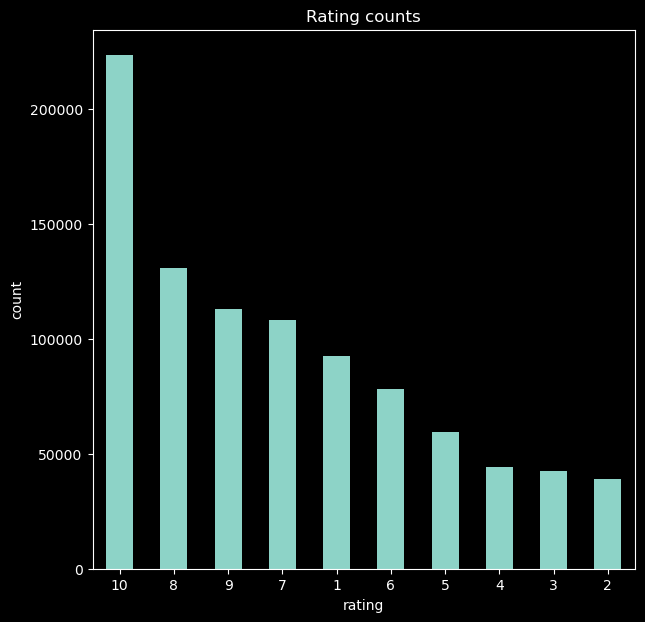

In [15]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))

df.rating.value_counts().plot.bar(ax=ax, rot=0)
ax.set_title('Rating counts')
ax.set_xlabel('rating')
ax.set_ylabel('count')

plt.show()

In [16]:
num_of_ratings_per_user = df.user_id.value_counts(sort=False)
num_of_ratings_per_user

user_id
b'ur2488512'     1791
b'ur60496217'       5
b'ur47207197'       1
b'ur0475177'        6
b'ur18827378'      11
                 ... 
b'ur59714635'       1
b'ur74721291'       1
b'ur71348327'       1
b'ur62915242'       1
b'ur7192529'        1
Name: count, Length: 445693, dtype: int64

In [17]:
unique_vals = num_of_ratings_per_user.unique()
len(unique_vals)

380

In [18]:
data = dict()
thres = 4

data[f'>= {thres}'] = 0

for value in unique_vals:
    if value >= thres:
        data[f'>= {thres}'] += len(num_of_ratings_per_user[num_of_ratings_per_user == value])
        continue
    data[str(value)] = len(num_of_ratings_per_user[num_of_ratings_per_user == value])

In [19]:
data = {k: v for k, v in sorted(data.items(), key=lambda item: item[1], reverse=True)}
data

{'1': 355302, '2': 46737, '>= 4': 27445, '3': 16209}

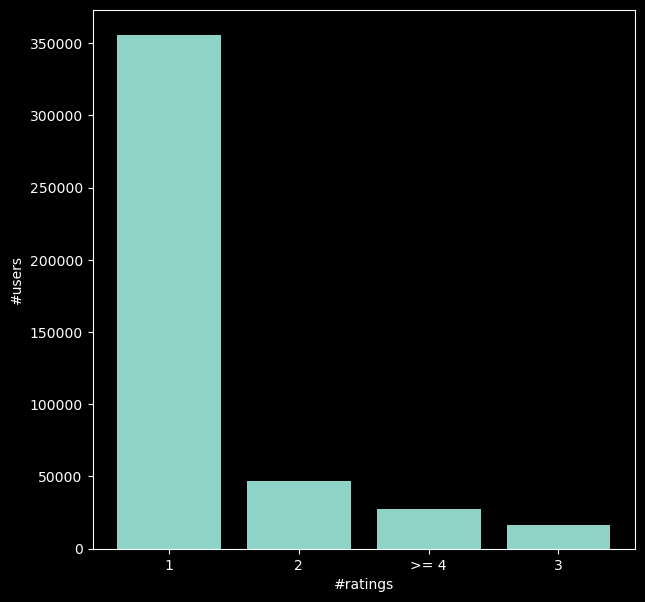

In [20]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.bar(data.keys(), data.values())
ax.set_ylabel('#users')
ax.set_xlabel('#ratings')

plt.show()

In [23]:
num_of_ratings_per_movie = df.movie_id.value_counts(sort=False)
unique_vals = num_of_ratings_per_movie.unique()
len(unique_vals)

436

In [24]:
data = dict()
thres = 10

data[f'>= {thres}'] = 0

for value in unique_vals:
    if value >= thres:
        data[f'>= {thres}'] += len(num_of_ratings_per_movie[num_of_ratings_per_movie == value])
        continue
    data[str(value)] = len(num_of_ratings_per_movie[num_of_ratings_per_movie == value])

data = {k: v for k, v in sorted(data.items(), key=lambda item: item[1], reverse=True)}
data

{'1': 86890,
 '2': 25388,
 '>= 10': 15195,
 '3': 12246,
 '4': 7345,
 '5': 4880,
 '6': 3515,
 '7': 2605,
 '8': 2109,
 '9': 1652}

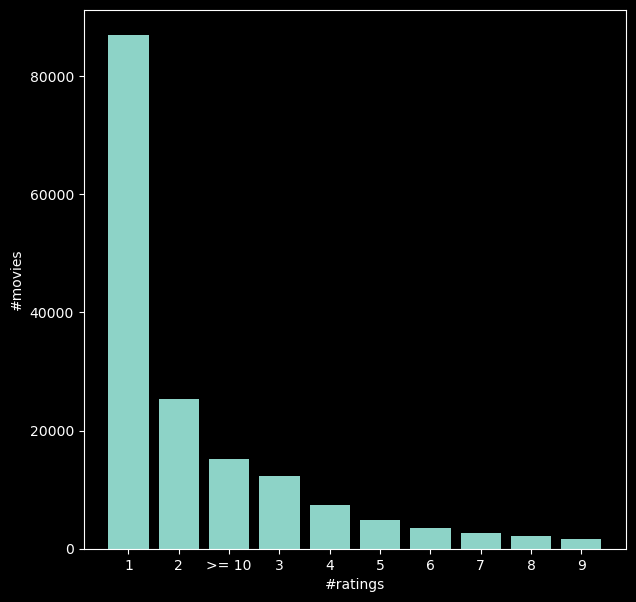

In [25]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.bar(data.keys(), data.values())
ax.set_ylabel('#movies')
ax.set_xlabel('#ratings')

plt.show()

In [26]:
movies_subset = list(num_of_ratings_per_movie[num_of_ratings_per_movie >= 800].index)
users_subset = list(num_of_ratings_per_user[num_of_ratings_per_user >= 4].index)

f'{len(movies_subset)=}', f'{len(users_subset)=}'

('len(movies_subset)=18', 'len(users_subset)=27445')

In [27]:
chunk_size_users = 1000
chunk_size_movies = 9

D = np.zeros((len(users_subset), len(movies_subset)), dtype=np.uint8)

for start_user in range(0, len(users_subset), chunk_size_users):
    users_chunk = users_subset[start_user:start_user + chunk_size_users]
    for start_movie in range(0, len(movies_subset), chunk_size_movies):
        movies_chunk = movies_subset[start_movie:start_movie + chunk_size_movies]

        mask_user = df['user_id'].isin(users_chunk)
        mask_movie = df['movie_id'].isin(movies_chunk)

        mask = df[mask_user & mask_movie]

        for index, row in mask.iterrows():
            user_index = users_subset.index(row['user_id'])
            movie_index = movies_subset.index(row['movie_id'])
            D[user_index, movie_index] = row['rating']

In [28]:
np.count_nonzero(D) / D.size * 100

0.7066658569664582

In [29]:
D[0, :], D[1, :]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

/tmp/ipykernel_3081/75677967.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[1] = plt.subplot(gs[1])


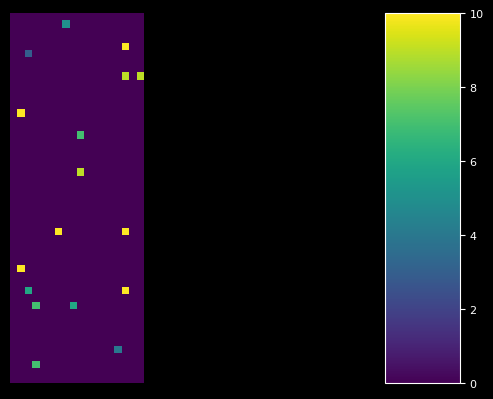

In [30]:
from matplotlib import gridspec

_, ax = plt.subplots(1, 2)

im = ax[0].imshow(D[:50, :])
ax[0].axis('off')

gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1])
ax[1] = plt.subplot(gs[1])
cbar = plt.colorbar(im, cax=ax[1])
cbar.ax.tick_params(labelsize=8)

plt.show()

In [31]:
np.save('D_matrix.npy', D)